In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import os
import requests
import dateutil
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", 300)

In [2]:
# scraping the links to all country profiles of the EU Emergency Trust fund
html_str = urlopen("https://ec.europa.eu/trustfundforafrica/region_en").read()
overview_page = BeautifulSoup(html_str, "html.parser")

trustfund_countries = []

for link in overview_page.findAll('a', href=True):
    country_dict = {}
    if 'region' in link['href']:
        if '_en' not in link['href']:
            if '/regional' not in link['href']:
                link = link['href']
                country_dict["country_profile_url"] = 'https://ec.europa.eu'+link
                country_name = re.sub('(\/\D*\/)(\D*)', r'\2', link)
                country_dict["country_name"]= country_name
                trustfund_countries.append(country_dict)
                
df = pd.DataFrame(trustfund_countries)

In [3]:
# scraping the download link to project data csv file on each country profile
data_links = []

for row in df["country_profile_url"]:
    html_str_temp = urlopen(row).read()
    country_page = BeautifulSoup(html_str_temp, "html.parser")
    for reference in country_page.findAll('a', href=True, text='CSV'):
        data_link = 'https://ec.europa.eu'+reference['href']
        data_links.append(data_link)
        
df['data_links'] = data_links

In [4]:
# downloading the csv file for each country

today=str(datetime.today().strftime("%Y-%m-%d"))

! mkdir data/trustfund_data_scraped_{today}

loop_count = 0
for url in df["data_links"]:
    response = requests.get(url)
    file_location = "data/trustfund_data_scraped_"+today
    with open(os.path.join(file_location, "file"+str(loop_count)+".csv"), 'wb') as f:
        f.write(response.content)
    loop_count = loop_count + 1

In [5]:
# reading in the csv files

trustfund_projects = pd.DataFrame()

file_number = list(range(0,loop_count,1))

for number in file_number:
    df = pd.read_csv(file_location+"/file"+str(number)+".csv", encoding = "latin-1")
    trustfund_projects = trustfund_projects.append(df, ignore_index=True)

In [6]:
trustfund_projects.head()

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,Adoption date,End date,Start date
0,Research and Evidence Facility for the Sahel a...,8000000.0,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,NaN,15/11/2020,15/11/2017
1,Technical Cooperation Facility,5000000.0,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,NaN,15/11/2020,15/11/2017
2,"Programme ""LRRD"" de renforcement de la résilie...",30000000.0,"LVIA, Handicap International, Terre des hommes...",Burkina Faso,"Boucle du Mouhoun, Sahel, Nord, Est",Strengthening resilience,18/04/2016,15/11/2020,15/11/2017
3,Insertion et Stabilisation Socio - Economique ...,5200000.0,MAECI DGCS - Ministero degli Affari Esteri e d...,Burkina Faso,Sahel,Greater economic and employment opportunities,18/04/2016,15/11/2020,15/11/2017
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.0,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,13/06/2016,15/11/2020,15/11/2017


In [7]:
#use regex to convert to yyyy-mm-dd format so that dateutil can convert easily

def date_conversion(str_date):
    try:
        new = re.sub('(\d\d)\/(\d\d)\/(\d\d\d\d)', r'\3-\2-\1', str_date)
        return dateutil.parser.parse(new)
    except:
        pass

In [8]:
trustfund_projects['start_date'] = trustfund_projects["Start date"].apply(date_conversion)
trustfund_projects['end_date'] = trustfund_projects['End date'].apply(date_conversion)
trustfund_projects['adoption_date'] = trustfund_projects['Adoption date'].apply(date_conversion)

In [9]:
trustfund_projects.head()

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,Adoption date,End date,Start date,start_date,end_date,adoption_date
0,Research and Evidence Facility for the Sahel a...,8000000.0,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,NaN,15/11/2020,15/11/2017,2017-11-15,2020-11-15,NaT
1,Technical Cooperation Facility,5000000.0,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,NaN,15/11/2020,15/11/2017,2017-11-15,2020-11-15,NaT
2,"Programme ""LRRD"" de renforcement de la résilie...",30000000.0,"LVIA, Handicap International, Terre des hommes...",Burkina Faso,"Boucle du Mouhoun, Sahel, Nord, Est",Strengthening resilience,18/04/2016,15/11/2020,15/11/2017,2017-11-15,2020-11-15,2016-04-18
3,Insertion et Stabilisation Socio - Economique ...,5200000.0,MAECI DGCS - Ministero degli Affari Esteri e d...,Burkina Faso,Sahel,Greater economic and employment opportunities,18/04/2016,15/11/2020,15/11/2017,2017-11-15,2020-11-15,2016-04-18
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.0,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,13/06/2016,15/11/2020,15/11/2017,2017-11-15,2020-11-15,2016-06-13


In [10]:
#including only the date columns that are in date format
# trustfund_projects=trustfund_projects[['Title', 'Budget', 'Implementing partners', 'Country', 'Location', 'Thematic', 'start_date', 'end_date', 'adoption_date']]
trustfund_projects=trustfund_projects[['Title', 'EUTF contribution', 'Implementing partners', 'Country', 'Location', 'Thematic', 'start_date', 'end_date', 'adoption_date']]

## SPECS

### All projects

In [11]:
number_all_projects = trustfund_projects['Title'].count()
number_all_projects

298

In [12]:
# 275 projects altogether, budget sum
# total_budget = trustfund_projects['Budget'].sum()
total_budget = trustfund_projects['EUTF contribution'].sum()

total_budget

4266026993.2799997

In [13]:
trustfund_projects['start_date'].value_counts()

2017-11-15    298
Name: start_date, dtype: int64

In [14]:
trustfund_projects['end_date'].value_counts()

2020-11-15    298
Name: end_date, dtype: int64

### Adopted projects

In [15]:
trustfund_projects['adoption_date'].value_counts()

2016-12-14    37
2016-04-18    27
2016-01-14    12
2016-06-13    11
Name: adoption_date, dtype: int64

In [16]:
number_adopted_projects = trustfund_projects[trustfund_projects['adoption_date'].notnull()]['Title'].count()
number_adopted_projects

87

In [17]:
adopted_budget = trustfund_projects[trustfund_projects['adoption_date'].notnull()]['EUTF contribution'].sum()
adopted_budget

1432723066.0

In [18]:
percent_adopted_budget = adopted_budget/total_budget * 100

### Started projects

In [19]:
number_started_projects = trustfund_projects[trustfund_projects['start_date']<datetime.today().strftime("%Y-%m-%d")]["Title"].count()
number_started_projects

298

In [20]:
started_projects_budget = trustfund_projects[trustfund_projects['start_date']<datetime.today().strftime("%Y-%m-%d")]['EUTF contribution'].sum()
started_projects_budget

4266026993.2799997

In [21]:
percent_started_budget = started_projects_budget/total_budget * 100

## Current status overview

In [22]:
print("On",datetime.today().strftime("%Y-%m-%d"),"the number of all projects listed in the EU emergency trust fund for Africa is",number_all_projects)
print("The budget total is",total_budget,"euros.")
print(" ")
print("Of the total",number_all_projects,"projects",number_adopted_projects, "have the status 'adopted'")
print("The budget of the adopted projects is", adopted_budget,"euros.")
print("The budget of the adopted projects account for",int(percent_adopted_budget),"percent of the total budget")
print(" ")
print("Of the total",number_all_projects,"projects",number_started_projects, "have a start date that is in the past")
print("The budget of all started projects is", started_projects_budget,"euros.")
print("The budget of all started projects account for",int(percent_started_budget),"percent of the total budget")

On 2018-02-14 the number of all projects listed in the EU emergency trust fund for Africa is 298
The budget total is 4266026993.28 euros.
 
Of the total 298 projects 87 have the status 'adopted'
The budget of the adopted projects is 1432723066.0 euros.
The budget of the adopted projects account for 33 percent of the total budget
 
Of the total 298 projects 298 have a start date that is in the past
The budget of all started projects is 4266026993.28 euros.
The budget of all started projects account for 100 percent of the total budget


## List of started projects

In [23]:
trustfund_projects[trustfund_projects['start_date']<datetime.today().strftime("%Y-%m-%d")]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
0,Research and Evidence Facility for the Sahel a...,8000000.00,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,2017-11-15,2020-11-15,NaT
1,Technical Cooperation Facility,5000000.00,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,2017-11-15,2020-11-15,NaT
2,"Programme ""LRRD"" de renforcement de la résilie...",30000000.00,"LVIA, Handicap International, Terre des hommes...",Burkina Faso,"Boucle du Mouhoun, Sahel, Nord, Est",Strengthening resilience,2017-11-15,2020-11-15,2016-04-18
3,Insertion et Stabilisation Socio - Economique ...,5200000.00,MAECI DGCS - Ministero degli Affari Esteri e d...,Burkina Faso,Sahel,Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.00,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
5,Renforcement de la gestion et de la gouvernanc...,8300000.00,International Organization for Migration,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved migration management,2017-11-15,2020-11-15,2016-12-14
6,Programme d?appui à l?Emploi dans les zones fr...,7000000.00,Expertise France,Burkina Faso,"Boucle du Mouhoun, Nord, Sahel",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
7,"TUUMA - Appui à la compétence professionnelle,...",8000000.00,Austrian Development Agency,Burkina Faso,"Cascades, Hauts-Bassins, Boucle du Mouhoun, Nord",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
8,Protection des jeunes dans les zones à risque ...,9000000.00,NaN,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Greater economic and employment opportunities,2017-11-15,2020-11-15,NaT
9,Prévention de l?extrémisme violent autochtone ...,7000000.00,NaN,Burkina Faso,Nord,Improved governance and conflict prevention,2017-11-15,2020-11-15,NaT


## List of adopted projects

In [24]:
trustfund_projects[trustfund_projects['adoption_date'].notnull()]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
2,"Programme ""LRRD"" de renforcement de la résilie...",30000000.0,"LVIA, Handicap International, Terre des hommes...",Burkina Faso,"Boucle du Mouhoun, Sahel, Nord, Est",Strengthening resilience,2017-11-15,2020-11-15,2016-04-18
3,Insertion et Stabilisation Socio - Economique ...,5200000.0,MAECI DGCS - Ministero degli Affari Esteri e d...,Burkina Faso,Sahel,Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.0,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
5,Renforcement de la gestion et de la gouvernanc...,8300000.0,International Organization for Migration,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved migration management,2017-11-15,2020-11-15,2016-12-14
6,Programme d?appui à l?Emploi dans les zones fr...,7000000.0,Expertise France,Burkina Faso,"Boucle du Mouhoun, Nord, Sahel",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
7,"TUUMA - Appui à la compétence professionnelle,...",8000000.0,Austrian Development Agency,Burkina Faso,"Cascades, Hauts-Bassins, Boucle du Mouhoun, Nord",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
11,Appui à la coopération régionale des pays du G...,7000000.0,Civipol,"Mali, Niger, Mauritanie, Burkina Faso, Tchad","Bamako, Gao, Kayes, Sikasso, Tombouctou, Segou...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-01-14
12,Support to the strengthening of police informa...,5000000.0,Interpol,"Burkina Faso, Mali, Mauritanie, Niger, Tchad, ...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-04-18
13,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.0,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
14,Renforcement de la résilience et de la capacit...,20000000.0,United Nations High Commissioner for Refugees,"Mauritanie, Burkina Faso, Mali, Niger","Hodh ech Chargui, Sahel, Tombouctou, Mopti, Ki...",Strengthening resilience,2017-11-15,2020-11-15,2016-12-14


## List of all projects

In [25]:
trustfund_projects

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
0,Research and Evidence Facility for the Sahel a...,8000000.00,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,2017-11-15,2020-11-15,NaT
1,Technical Cooperation Facility,5000000.00,NaN,"Nigeria, Niger, Mauritanie, Mali, Guinée, Ghan...","Zamfara, Sokoto, Taraba, Yobe, Rivers, Plateau...",NaN,2017-11-15,2020-11-15,NaT
2,"Programme ""LRRD"" de renforcement de la résilie...",30000000.00,"LVIA, Handicap International, Terre des hommes...",Burkina Faso,"Boucle du Mouhoun, Sahel, Nord, Est",Strengthening resilience,2017-11-15,2020-11-15,2016-04-18
3,Insertion et Stabilisation Socio - Economique ...,5200000.00,MAECI DGCS - Ministero degli Affari Esteri e d...,Burkina Faso,Sahel,Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.00,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
5,Renforcement de la gestion et de la gouvernanc...,8300000.00,International Organization for Migration,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved migration management,2017-11-15,2020-11-15,2016-12-14
6,Programme d?appui à l?Emploi dans les zones fr...,7000000.00,Expertise France,Burkina Faso,"Boucle du Mouhoun, Nord, Sahel",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
7,"TUUMA - Appui à la compétence professionnelle,...",8000000.00,Austrian Development Agency,Burkina Faso,"Cascades, Hauts-Bassins, Boucle du Mouhoun, Nord",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-12-14
8,Protection des jeunes dans les zones à risque ...,9000000.00,NaN,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Greater economic and employment opportunities,2017-11-15,2020-11-15,NaT
9,Prévention de l?extrémisme violent autochtone ...,7000000.00,NaN,Burkina Faso,Nord,Improved governance and conflict prevention,2017-11-15,2020-11-15,NaT


In [26]:
#export as csv
trustfund_projects.to_csv("data/all_trustfund_projects_"+today+".csv")

## Data analysis

### Budget data
-thematic analysis
-countries
-countries&thematic

In [27]:
trustfund_projects['EUTF contribution'].mean()

14315526.823087247

In [28]:
trustfund_projects['EUTF contribution'].median()

9900000.0

In [29]:
trustfund_projects['EUTF contribution'].min()

75000.0

In [30]:
max_single_budget = trustfund_projects['EUTF contribution'].max()
max_single_budget

90000000.0

In [31]:
trustfund_projects[trustfund_projects['EUTF contribution']== max_single_budget]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
273,Managing mixed migration flows in Libya throug...,90000000.0,"International Organization for Migration, Unit...",Libya,"Al Bu?n?n, Al Jabal al Akh?ar, Al Jabal al Gha...",Improved migration management,2017-11-15,2020-11-15,NaT


In [32]:
trustfund_projects[trustfund_projects['Country']== "Libya"]['EUTF contribution'].sum()

157923927.28

In [33]:
trustfund_projects[trustfund_projects['Country']== "Libya"]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
271,Strengthening protection and resilience of dis...,5900000.00,Danish Refugee Council,Libya,"Al Bu?n?n, Al Jabal al Akh?ar, Al Jabal al Gha...",Improved migration management,2017-11-15,2020-11-15,NaT
272,Supporting protection and humanitarian repatri...,19800000.00,International Organization for Migration,Libya,"Al Bu?n?n, Al Jabal al Akh?ar, Al Jabal al Gha...",Improved migration management,2017-11-15,2020-11-15,NaT
273,Managing mixed migration flows in Libya throug...,90000000.00,"International Organization for Migration, Unit...",Libya,"Al Bu?n?n, Al Jabal al Akh?ar, Al Jabal al Gha...",Improved migration management,2017-11-15,2020-11-15,NaT
274,Support to Integrated border and migration man...,42223927.28,Italian Ministry of Interior,Libya,"?ar?bulus, Gh?t",Improved migration management,2017-11-15,2020-11-15,NaT


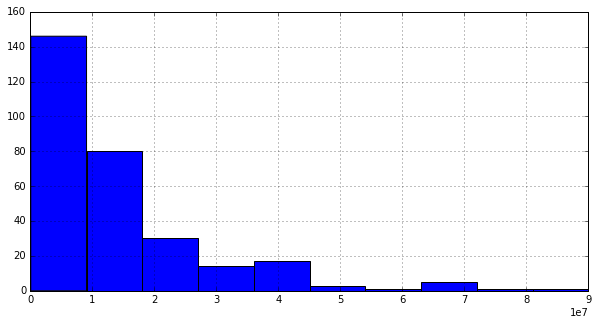

In [34]:
trustfund_projects['EUTF contribution'].hist(figsize = (10,5))

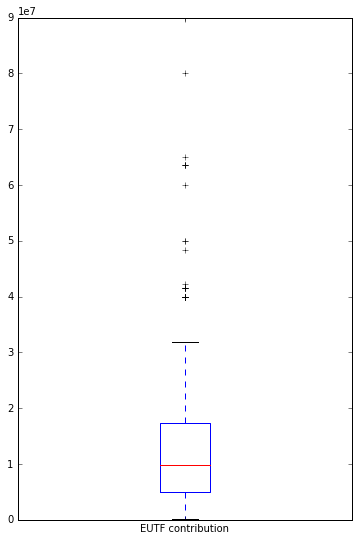

In [35]:
trustfund_projects['EUTF contribution'].plot(kind = 'box', figsize = (6,9))

In [36]:
print("A quarter of all projects have a budet of", int(trustfund_projects.quantile(q=0.25)), "euros or less")
print("Half of all projects have a budget of", int(trustfund_projects.quantile(q=0.5)), "euros or less")
print("Three quarters of all projects have a budget of", int(trustfund_projects.quantile(q=0.75)), "euros or less")

A quarter of all projects have a budet of 5000000 euros or less
Half of all projects have a budget of 9900000 euros or less
Three quarters of all projects have a budget of 17400000 euros or less


In [37]:
iqr = trustfund_projects.quantile(q=0.75) - trustfund_projects.quantile(q=0.25)

upper_acceptance_limit = int(trustfund_projects['EUTF contribution'].quantile(q=0.75) + (iqr * 1.5))
lower_acceptance_limit = int(trustfund_projects['EUTF contribution'].quantile(q=0.25) - (iqr * 1.5))

print("A project receives significantly less than average projects when it has a budget of less than", lower_acceptance_limit)
print("This is the case for",trustfund_projects[trustfund_projects['EUTF contribution'] <= lower_acceptance_limit]["Title"].count(),"projects")

print("A project receives significantly more than average projects when it has a budget of more than", upper_acceptance_limit)
print("This is the case for",trustfund_projects[trustfund_projects['EUTF contribution'] >= upper_acceptance_limit]["Title"].count(),"projects")

A project receives significantly less than average projects when it has a budget of less than -13600000
This is the case for 0 projects
A project receives significantly more than average projects when it has a budget of more than 36000000
This is the case for 28 projects


### List of projects with significantly more budget than the average project

In [38]:
trustfund_projects[trustfund_projects['EUTF contribution'] >= upper_acceptance_limit]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
10,Appui budgétaire pour la mise en ?uvre du Prog...,50000000.00,NaN,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,NaT
13,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
43,Programme d'appui à l'intégration socio-économ...,65000000.00,"ITC - International Trade Center, GIZ, Belgian...",Guinée,"Beyla, Boffa, Boké, Coyah, Dabola, Dalaba, Din...",Greater economic and employment opportunities,2017-11-15,2020-11-15,NaT
61,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
79,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
91,Contrat relatif à la Reconstruction de l'Etat ...,80000000.00,"Agence Française de Développement, Civipol",Niger,"Niamey, Zinder, Tahoua, Agadez",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
99,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
119,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
125,Développer l'emploi au Sénégal: renforcement d...,40000000.00,"Luxembourg Development Cooperation Agency, GRE...",Senegal,"Kédougou, Diourbel, Kolda, Sédhiou, Tambacound...",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
136,GAR-SI SAHEL (Groupes d?Action Rapides ? Surve...,41600000.00,Fundación Internacional y para Iberoamérica de...,"Burkina Faso, Mali, Mauritanie, Niger, Senegal...","Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13


### Thematic analysis

In [39]:
trustfund_projects["Thematic"].value_counts()

Improved migration management                    82
Greater economic and employment opportunities    78
Improved governance and conflict prevention      43
Strengthening resilience                         36
Name: Thematic, dtype: int64

In [60]:
purposes = ["Improved migration management", "Greater economic and employment opportunities","Improved governance and conflict prevention", "Strengthening resilience"]

financial_priorities = []

for purpose in purposes:
    purpose_dict ={}
    purpose_dict['purpose']= purpose
    purpose_dict['amount']= trustfund_projects[trustfund_projects['Thematic']==purpose]['EUTF contribution'].sum()
    financial_priorities.append(purpose_dict)
    
financial_priorities_df = pd.DataFrame(financial_priorities)
financial_priorities_df

,amount,purpose
0,1220981127.28,Improved migration management
1,1376433233.00,Greater economic and employment opportunities
2,727675000.00,Improved governance and conflict prevention
3,611737633.00,Strengthening resilience


In [62]:
sum_priorities = financial_priorities_df['amount'].sum()
sum_priorities

3936826993.2799997

In [93]:
for purpose in financial_priorities_df['purpose']:
    purpose_budget = financial_priorities_df[financial_priorities_df['purpose']==purpose]['amount'].sum()
    purpse_share = int(purpose_budget/sum_priorities*100)
    print(purpose,"receives",purpose_budget,"euros in EUTF funds, which equals",purpse_share,"percent.")

Improved migration management receives 1220981127.28 euros in EUTF funds, which equals 31 percent.
Greater economic and employment opportunities receives 1376433233.0 euros in EUTF funds, which equals 34 percent.
Improved governance and conflict prevention receives 727675000.0 euros in EUTF funds, which equals 18 percent.
Strengthening resilience receives 611737633.0 euros in EUTF funds, which equals 15 percent.


In [71]:
# total budget higher than sum of prurposes -- where does the gap come from?
sum_trustfund = trustfund_projects['EUTF contribution'].sum()
sum_trustfund

4266026993.2799997

In [83]:
print("Explanantion: There are 59 projects that do not have an assigned purpose. They have a budget of",int((sum_trustfund - sum_priorities)/1000000),"million euros")

Explanantion: There are 59 projects that do not have an assigned purpose. They have a budget of 329 million euros


In [92]:
for purpose in financial_priorities_df['purpose']:
    purpose_budget = financial_priorities_df[financial_priorities_df['purpose']==purpose]['amount'].sum()
    purpse_share2total = int(purpose_budget/sum_trustfund*100)
    print(purpose,"receives",purpose_budget,"euros in EUTF funds, which equals",purpse_share2total,"percent.")
    
non_purpose_budget = sum_trustfund - sum_priorities
    
print("Some projects don't have an assigned purpose, they receive",non_purpose_budget, "euros in EUTF funds, which euqals",int(non_purpose_budget/sum_trustfund*100), "percent." )

Improved migration management receives 1220981127.28 euros in EUTF funds, which equals 28 percent.
Greater economic and employment opportunities receives 1376433233.0 euros in EUTF funds, which equals 32 percent.
Improved governance and conflict prevention receives 727675000.0 euros in EUTF funds, which equals 17 percent.
Strengthening resilience receives 611737633.0 euros in EUTF funds, which equals 14 percent.
Some projects don't have an assigned purpose, they receive 329200000.0 euros in EUTF funds, which euqals 7 percent.


In [101]:
undef_purpose_dict = {'amount': sum_trustfund - sum_priorities, 'purpose': "unknown_purpose"}

In [102]:
financial_priorities_df.append(undef_purpose_dict, ignore_index=True)

,amount,purpose
0,1220981127.28,Improved migration management
1,1376433233.00,Greater economic and employment opportunities
2,727675000.00,Improved governance and conflict prevention
3,611737633.00,Strengthening resilience
4,329200000.00,unknown_purpose


In [107]:
financial_priorities_df.to_csv("test.csv")

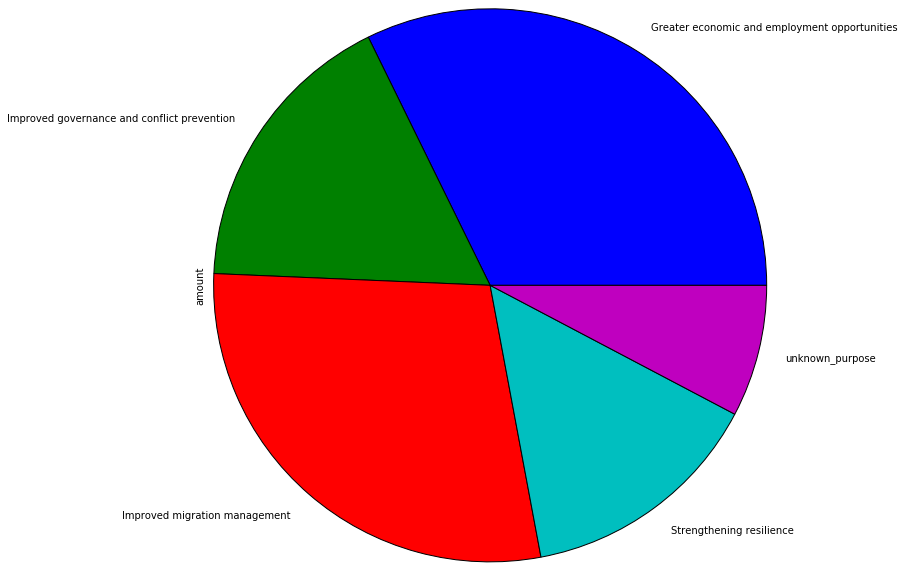

In [115]:
financial_priorities_df.plot(kind="pie", y='amount',figsize = (10,10))
plt.axis('equal')

# plt.savefig("VisualDrafts/EUTF-bypurpose2.pdf", transparent = True)

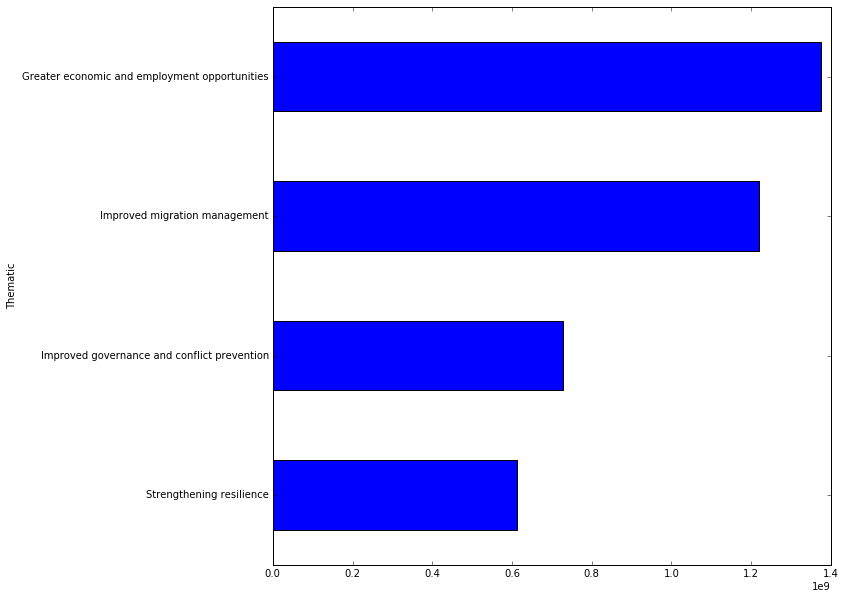

In [42]:
trustfund_projects.groupby(by="Thematic")['EUTF contribution'].sum().sort_values(ascending=True).plot(kind="barh", figsize = (10,10))

# plt.savefig("VisualDrafts/EUTF-bypurpose-barh.pdf", transparent = True)

In [43]:
trustfund_projects.groupby(by="Thematic")['EUTF contribution'].median()

Thematic
Greater economic and employment opportunities   13788116.50
Improved governance and conflict prevention      7000000.00
Improved migration management                   10000000.00
Strengthening resilience                        20000000.00
Name: EUTF contribution, dtype: float64

In [44]:
trustfund_projects.groupby(by="Thematic")['EUTF contribution'].max()

Thematic
Greater economic and employment opportunities   65000000.00
Improved governance and conflict prevention     80000000.00
Improved migration management                   90000000.00
Strengthening resilience                        31900000.00
Name: EUTF contribution, dtype: float64

## Overview of all projects of a certain type

In [45]:
trustfund_projects[trustfund_projects['Thematic']=="Improved migration management"].sort_values(by="EUTF contribution", ascending = False)

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
273,Managing mixed migration flows in Libya throug...,90000000.00,"International Organization for Migration, Unit...",Libya,"Al Bu?n?n, Al Jabal al Akh?ar, Al Jabal al Gha...",Improved migration management,2017-11-15,2020-11-15,NaT
264,Enhancing the Response to Migration Challenges...,60000000.00,MAECI DGCS - Ministero degli Affari Esteri e d...,Egypt,"Al Sharqia, Alexandria, Aswan, Asyut, Beheira,...",Improved migration management,2017-11-15,2020-11-15,NaT
274,Support to Integrated border and migration man...,42223927.28,Italian Ministry of Interior,Libya,"?ar?bulus, Gh?t",Improved migration management,2017-11-15,2020-11-15,NaT
198,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
164,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
177,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
189,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
211,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
225,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
246,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT


### Country analysis

In [47]:
#list of EUTF single recipient countries
recipient_countries = ["Nigeria","Niger","Mauritanie","Mali","Guinée","Ghana","Côte d'Ivoire","Tunisia","Morocco","Libya","Egypt","Algeria","Uganda","Tanzania","Cameroun","Sudan","South Sudan","Somalia","Kenya","Ethiopia","Eritrea","Djibouti","The Gambia","Tchad","Senegal","Burkina Faso"]

In [49]:
theme_list = ['Greater economic and employment opportunities','Improved migration management','Improved governance and conflict prevention','Strengthening resilience']

recipient_list = []

for country in recipient_countries:
    recipient_dict ={}
    recipient_dict['unique_recipient'] = country
    recipient_dict['unique_money'] = int(trustfund_projects[trustfund_projects['Country'] == country]['EUTF contribution'].sum())
    for theme in theme_list:
        recipient_dict[theme] = int(trustfund_projects[(trustfund_projects['Country'] == country) & (trustfund_projects['Thematic']==theme)]['EUTF contribution'].sum())
    recipient_list.append(recipient_dict)
    
recipient_overview = pd.DataFrame(recipient_list)

In [50]:
recipient_overview.describe()

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money
count,26.00,26.00,26.00,26.00,26.00
mean,27501278.19,14349038.46,14750274.12,15666832.04,72855884.35
std,36643562.50,26740035.98,32463997.27,26854860.90,67066544.36
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,13475000.00
50%,12000000.00,0.00,3600000.00,0.00,57100000.00
75%,39894058.25,17000000.00,14075000.00,21500000.00,110725000.00
max,143857000.00,87000000.00,157923927.00,93300000.00,229900000.00


In [51]:
recipient_overview.sort_values(by="unique_money", ascending = False)

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money,unique_recipient
1,99900000,86000000,22000000,22000000,229900000,Niger
3,39576233,67000000,15000000,65000000,186576233,Mali
24,78000000,28000000,42203200,13600000,161803200,Senegal
19,143857000,0,0,0,158857000,Ethiopia
9,0,0,157923927,0,157923927,Libya
25,29200000,87000000,8300000,30000000,154500000,Burkina Faso
23,0,20000000,0,93300000,113300000,Tchad
17,58000000,45000000,0,0,103000000,Somalia
15,40000000,8000000,8000000,47000000,103000000,Sudan
0,0,21000000,15500000,42023633,78523633,Nigeria


In [52]:
recipient_overview.sort_values(by="Improved migration management", ascending = False)

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money,unique_recipient
9,0,0,157923927,0,157923927,Libya
10,0,0,60000000,0,60000000,Egypt
24,78000000,28000000,42203200,13600000,161803200,Senegal
1,99900000,86000000,22000000,22000000,229900000,Niger
0,0,21000000,15500000,42023633,78523633,Nigeria
3,39576233,67000000,15000000,65000000,186576233,Mali
21,10000000,0,15000000,0,25000000,Djibouti
7,0,0,11300000,0,11300000,Tunisia
2,37200000,6000000,11000000,0,54200000,Mauritanie
8,0,0,10080000,0,10080000,Morocco


In [53]:
recipient_overview.sort_values(by="Greater economic and employment opportunities", ascending = False)

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money,unique_recipient
19,143857000,0,0,0,158857000,Ethiopia
1,99900000,86000000,22000000,22000000,229900000,Niger
24,78000000,28000000,42203200,13600000,161803200,Senegal
4,65000000,0,0,0,65000000,Guinée
17,58000000,45000000,0,0,103000000,Somalia
12,44300000,0,0,0,44300000,Uganda
15,40000000,8000000,8000000,47000000,103000000,Sudan
3,39576233,67000000,15000000,65000000,186576233,Mali
2,37200000,6000000,11000000,0,54200000,Mauritanie
25,29200000,87000000,8300000,30000000,154500000,Burkina Faso


In [54]:
recipient_overview.sort_values(by="Improved governance and conflict prevention", ascending = False)

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money,unique_recipient
25,29200000,87000000,8300000,30000000,154500000,Burkina Faso
1,99900000,86000000,22000000,22000000,229900000,Niger
3,39576233,67000000,15000000,65000000,186576233,Mali
17,58000000,45000000,0,0,103000000,Somalia
24,78000000,28000000,42203200,13600000,161803200,Senegal
0,0,21000000,15500000,42023633,78523633,Nigeria
23,0,20000000,0,93300000,113300000,Tchad
15,40000000,8000000,8000000,47000000,103000000,Sudan
2,37200000,6000000,11000000,0,54200000,Mauritanie
18,29000000,5000000,0,0,34000000,Kenya


In [55]:
recipient_overview.sort_values(by="Strengthening resilience", ascending = False)

,Greater economic and employment opportunities,Improved governance and conflict prevention,Improved migration management,Strengthening resilience,unique_money,unique_recipient
23,0,20000000,0,93300000,113300000,Tchad
16,0,75000,0,74414000,74789000,South Sudan
3,39576233,67000000,15000000,65000000,186576233,Mali
15,40000000,8000000,8000000,47000000,103000000,Sudan
0,0,21000000,15500000,42023633,78523633,Nigeria
25,29200000,87000000,8300000,30000000,154500000,Burkina Faso
1,99900000,86000000,22000000,22000000,229900000,Niger
14,17000000,0,3300000,20000000,40300000,Cameroun
24,78000000,28000000,42203200,13600000,161803200,Senegal
6,0,0,0,0,0,Côte d'Ivoire


In [56]:
recipient_overview.to_csv("data/recipient_overview_sectoral"+str(today)+".csv")

In [57]:
# Show all projects with GIZ as sole partner
trustfund_projects[trustfund_projects['Implementing partners']== "GIZ"]

,Title,EUTF contribution,Implementing partners,Country,Location,Thematic,start_date,end_date,adoption_date
4,Programme d'Appui à la Gestion Intégrée des Fr...,30000000.00,GIZ,Burkina Faso,"Centre-Nord, Centre-Ouest, Centre-Sud, Centre-...",Improved governance and conflict prevention,2017-11-15,2020-11-15,2016-06-13
22,Projet d'Appui à la Résilience Socio-Économiqu...,7000000.00,GIZ,Cameroun,"Nord, Adamaoua, Extrême-Nord",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
58,Programme Jeunesse et Stabilisation ? PROJES ?...,30000000.00,GIZ,Mali,"Segou !Ségou, Mopti",Strengthening resilience,2017-11-15,2020-11-15,NaT
87,Renforcement de la gestion durable des conséqu...,25000000.00,GIZ,Niger,"Agadez, Tahoua, Zinder",Greater economic and employment opportunities,2017-11-15,2020-11-15,2016-04-18
142,Projet de Renforcement de la Résilience et de ...,18000000.00,GIZ,Tchad,"Sila, Tibesti, Salamat, Hadjer Lamis, Chari-Ba...",Strengthening resilience,2017-11-15,2020-11-15,2016-04-18
155,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
163,Support for the creation of employment opportu...,13000000.00,GIZ,Eritrea,"Northern Red Sea, Gash-Barka, Southern Red Sea...",Greater economic and employment opportunities,2017-11-15,2020-11-15,NaT
164,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
177,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT
189,Better Migration Management Programme,40000000.00,GIZ,"Ethiopia, Uganda, Somalia, Sudan, South Sudan,...","Addis Ababa, Afar, Tigrai, Southern Nations, N...",Improved migration management,2017-11-15,2020-11-15,NaT


In [58]:
trustfund_projects[trustfund_projects['Implementing partners']== "GIZ"]['EUTF contribution'].sum()

451000000.0